
Data augmentation on the GPU
============================

In this tutorial you will learn how to use `kornia` modules in order to perform the data augmentation on the GPU in batch mode.


[Colab Notebook](https://drive.google.com/open?id=1u390RrsOYnuLXKy3zyrRr5ja0Pdw1KI0)


In [11]:
!pip3 install git+https://github.com/arraiyopensource/kornia
!pip3 install torchvision

  Cloning https://github.com/arraiyopensource/kornia to /tmp/pip-b9vqf403-build
  Using cached https://files.pythonhosted.org/packages/88/95/90e8c4c31cfc67248bf944ba42029295b77159982f532c5689bcfe4e9108/torch-1.3.1-cp36-cp36m-manylinux1_x86_64.whl
  Cache entry deserialization failed, entry ignored
    100% |████████████████████████████████| 2.1MB 517kB/s ta 0:00:011
  Using cached https://files.pythonhosted.org/packages/d2/ab/43e678759326f728de861edbef34b8e2ad1b1490505f20e0d1f0716c3bf4/numpy-1.17.4-cp36-cp36m-manylinux1_x86_64.whl
  Running setup.py install for kornia ... done


In [29]:
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision.datasets import VOCDetection
from torchvision.transforms import Resize
import kornia
import torch
import cv2
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]
from PIL import Image

# Necessary to parse VOC Targets
import xml.etree.ElementTree as ET

# 1. Create VOC dataset

In [3]:
class VOC(VOCDetection):
    def __init__(self, root, download=False, transform=None):

        super(VOC, self).__init__(root, download=download, transform=transform)

    def __len__(self):
        return super(VOC, self).__len__()

    def __getitem__(self, index):

        img = Image.open(self.images[index]).convert("RGB")
        target = self.parse_voc_xml(ET.parse(self.annotations[index]).getroot())
        boxes = []
        target = target["annotation"]["object"]
        target = target if isinstance(target, list) else [target]

        # change to xmin, ymin, xmax, ymax
        box = target[0]["bndbox"]
        target = torch.FloatTensor(
            [
                float(box["xmin"]),
                float(box["xmax"]),
                float(box["ymin"]),
                float(box["ymax"]),
            ]
        )
        ow, oh = img.size

        # Reescale boxes
        target[:2].mul_(512 / ow)
        target[-2:].mul_(512 / oh)

        # Reorder boxes as xyxy
        perm = torch.LongTensor([0, 2, 1, 3])
        target = target[perm]

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

# 2. Define some utils functions to plot images

In [4]:
# Utils functions
def plot_images(org, img):

    fig, ax = plt.subplots(2, img.shape[0], sharex=True, sharey=True)
    fig.suptitle("Original (Top) / Trasnformed (Bottom)", fontsize=16)
    for b in range(img.shape[0]):
        ax[0, b].imshow(org[b])
        ax[1, b].imshow(img[b])

    plt.xticks([])
    plt.yticks([])
    plt.show()


def draw_boxes(original, images, transformed_targets, targets):

    for i in range(original.shape[0]):
        images[i] = cv2.rectangle(
            images[i],
            (transformed_targets[i][0], transformed_targets[i][1]),
            (transformed_targets[i][2], transformed_targets[i][3]),
            (0, 1, 0),
            2,
        ).get()
        original[i] = cv2.rectangle(
            original[i],
            (targets[i][0], targets[i][1]),
            (targets[i][2], targets[i][3]),
            (0, 1, 0),
            2,
        ).get()

    return original, images


def transform_boxes(mat, targets):

    return kornia.transform_points(mat, targets.view(-1, 2, 2).float()).view(-1, 4)

In [18]:
def augment(dataloader, boxes=False):
    # get next batch
    images, targets = next(iter(dataloader))

    # move tensors to GPU
    images = images.to(device) / 255
    targets = targets.to(device)

    # keep a copy of the original image
    original = kornia.tensor_to_image(images)

    # perform the transforms
    if boxes:
        images, mat = transform(images)
    else:
        images = transform(images)
    images = kornia.tensor_to_image(images)


    if boxes:
        # transform boxes
        transformed_targets = transform_boxes(mat, targets)

        # draw boxes
        original, images = draw_boxes(original, images, transformed_targets, targets)
        plot_images(original, images)
    else:
        plot_images(original, images)

# 3. Define the data augmentation operations

In [25]:
# Thanks to the `kornia` design all the operators can be placed inside inside a `nn.Sequential`.
transform = nn.Sequential(
    kornia.augmentation.ColorJitter(
        brightness=(0.0, 0.0),
        contrast=(1.0, 1.0),
        hue=1.5,
        saturation=2.0,
    ),
    kornia.augmentation.RandomHorizontalFlip(1.0),
)

# 4. Define Dataset & Dataloader

In [19]:
device = torch.device("cpu")
seed = 0
torch.manual_seed(seed)
print(f"Running with device: {device}")
print(f"Running with seed: {seed}")

# create the dataloader
batch_size = 4
dataset = VOC(
    root="data",
    download=True,
    transform=lambda x: kornia.image_to_tensor(Resize((512, 512))(x)),
)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

Running with device: cpu
Running with seed: 0
Using downloaded and verified file: data/VOCtrainval_11-May-2012.tar


# 5. Augment Images

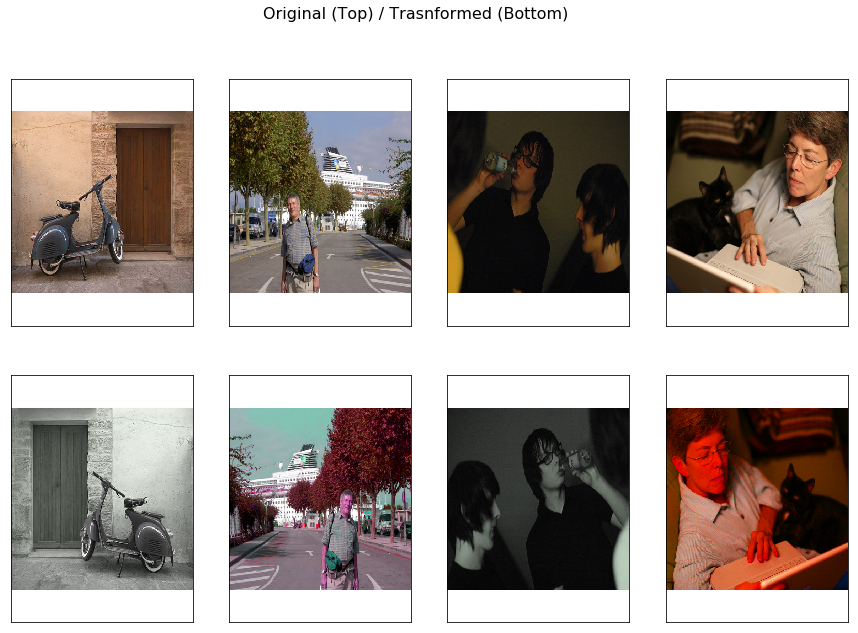

In [30]:
augment(dataloader)

In [31]:
transform = nn.Sequential(
    kornia.augmentation.ColorJitter(
        brightness=(0.0, 0.0),
        contrast=(1.0, 1.0),
        hue=1.5,
        saturation=2.0,
        return_transform=True,
    ),
    kornia.augmentation.RandomHorizontalFlip(1.0, return_transform=True),
)

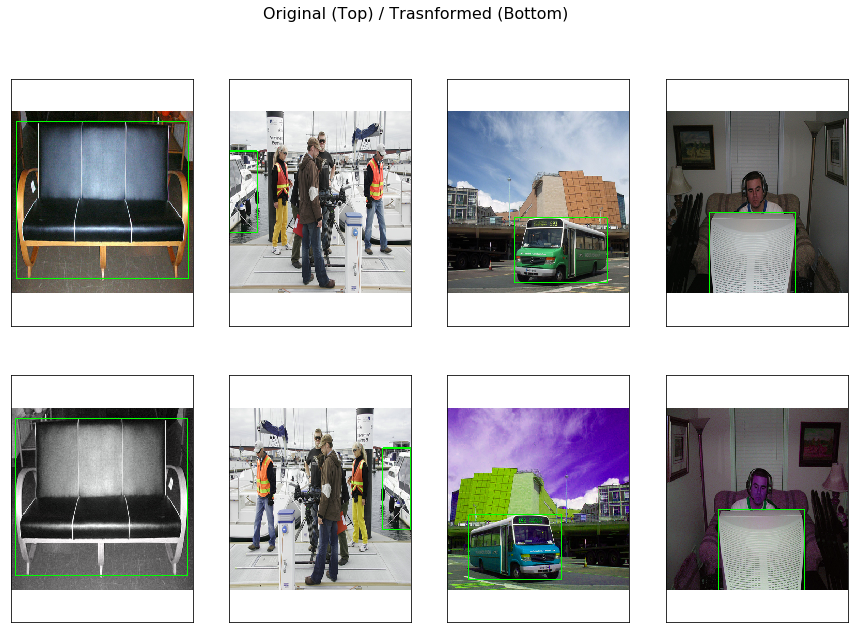

In [32]:
augment(dataloader, boxes=True)